In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
import utils as u
import importlib
importlib.reload(u)
import io
import requests
import pandas as pd

In [2]:
r_orb = requests.post(
  'https://fink-portal.org/api/v1/ssocand',
  json={
    'kind': 'orbParams', # Mandatory, `orbParams` or `lightcurves`
  }
)
r_tra = requests.post(
  'https://fink-portal.org/api/v1/ssocand',
  json={
    'kind': 'lightcurves', # Mandatory, `orbParams` or `lightcurves`
  }
)

# Format output in a DataFrame
candid_reconstr_orbit = pd.read_json(io.BytesIO(r_orb.content))
candid_reconstr_traje = pd.read_json(io.BytesIO(r_tra.content))


In [3]:
# Reconstructed
len(candid_reconstr_orbit), len(candid_reconstr_orbit[candid_reconstr_orbit["d:rms_a"] != -1.0])

(610, 327)

In [4]:
candid_reconstr_traje

,d:assoc_tag,d:candid,d:dcmag,d:dcmag_err,d:dec,d:fid,d:jd,d:magpsf,d:nid,d:objectId,d:ra,d:sigmapsf,d:ssoCandId
0,I,1035137672515015000,19.317945,0.153435,18.807126,2,2.458790e+06,19.384495,1035,ZTF19acmdutq,29.185301,0.162513,FF2022aaaaabx
1,I,1035138120115015013,19.260080,0.161881,23.551682,2,2.458790e+06,19.300814,1035,ZTF19acmdvqz,33.424714,0.167533,FF2022aaaaaac
2,I,1035138122815015004,19.122636,0.129413,25.719495,2,2.458790e+06,19.282640,1035,ZTF19acmdvtf,28.259642,0.149185,FF2022aaaaaae
3,I,1035138123915015011,18.791011,0.097298,26.513962,2,2.458790e+06,18.810448,1035,ZTF19acmdvrn,32.143513,0.098945,FF2022aaaaaai
4,I,1035165922515015001,19.776265,0.136739,18.800207,1,2.458790e+06,19.842577,1035,ZTF19acmebgc,29.180444,0.144382,FF2022aaaaabx
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754,A,2145149124615015168,15.394508,0.015814,-2.437865,1,2.459900e+06,15.395899,2145,ZTF22abubooh,358.521637,0.015832,FF2022aaaaaxk
3755,T,2145149124315015026,18.565031,0.084928,-2.164983,1,2.459900e+06,18.581163,2145,ZTF22abubofw,1.231779,0.086034,FF2022aaaaaxl
3756,T,2145173044315015013,18.019779,0.083950,-2.165056,2,2.459900e+06,18.030357,2145,ZTF22abubtig,1.231186,0.084725,FF2022aaaaaxl
3757,T,2147170624315015040,18.014472,0.086355,-2.167734,2,2.459902e+06,18.029590,2147,ZTF22abupatw,1.192095,0.087439,FF2022aaaaaxl


## Results

|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Reconstructed orbit | 610      | 327             |

### RMS compared to confirmed reconstruction

In [5]:
from collections import Counter

reconstructed_orbit = pd.read_parquet("../fink_fat_experiments/confirmed_all_fink_fat/mpc/orbital.parquet")
reconstructed_trajectory = pd.read_parquet("../fink_fat_experiments/confirmed_all_fink_fat/mpc/trajectory_orb.parquet")

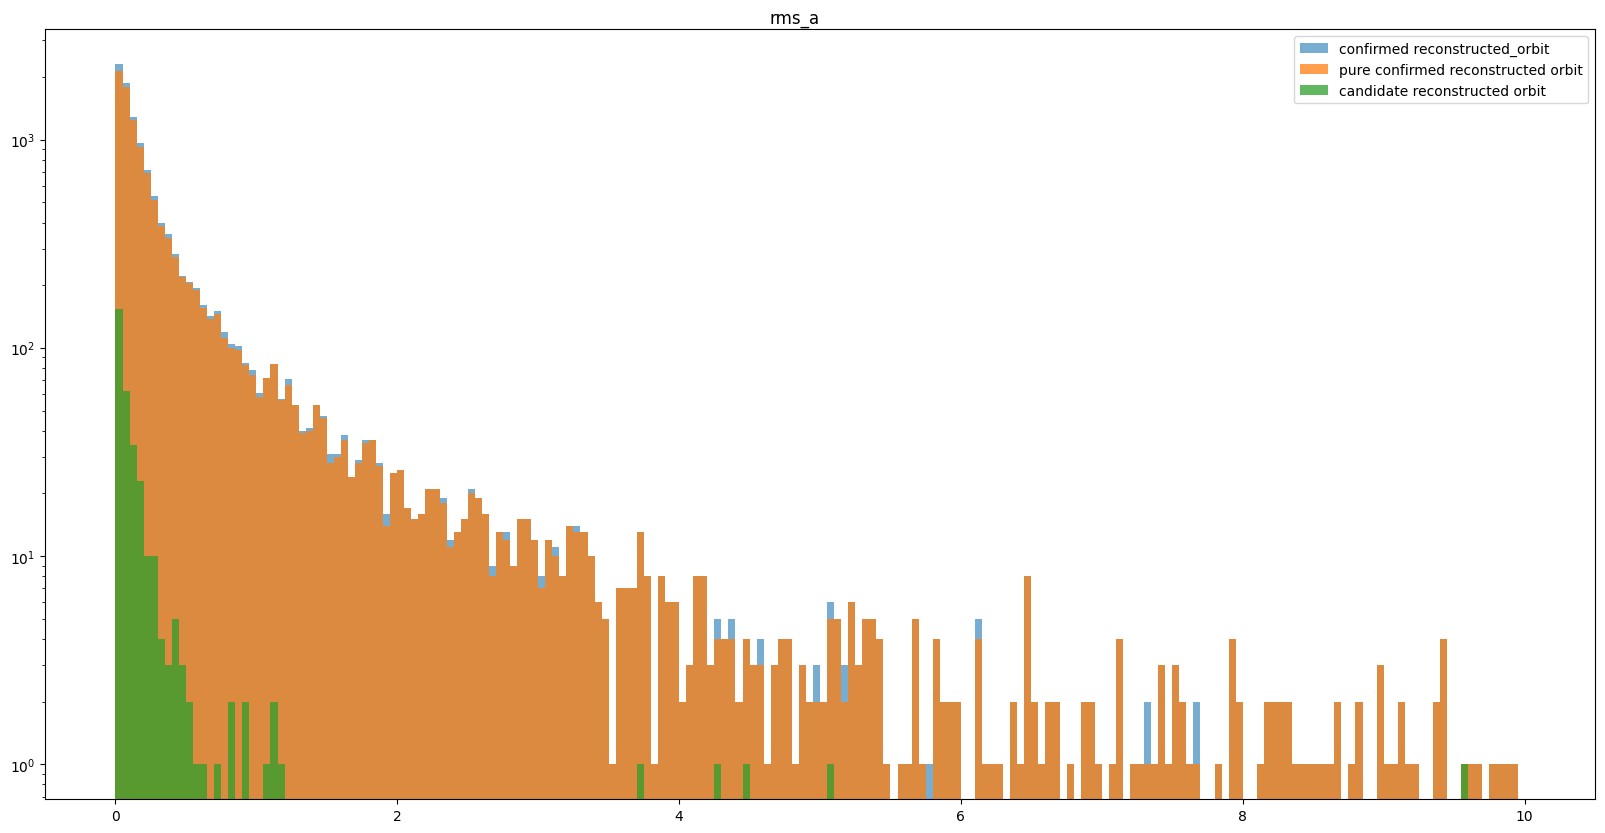

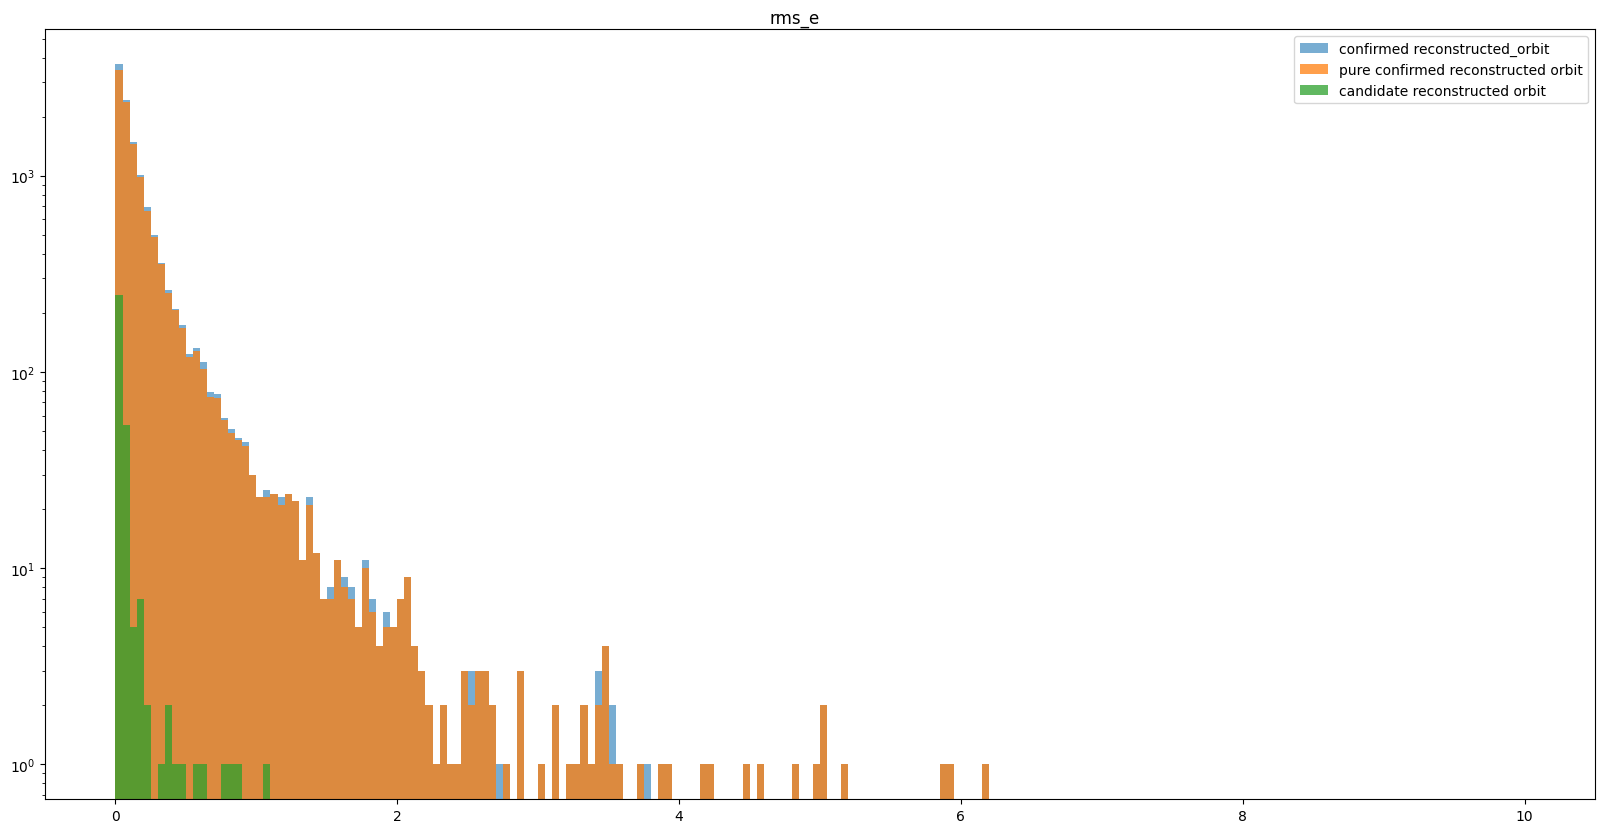

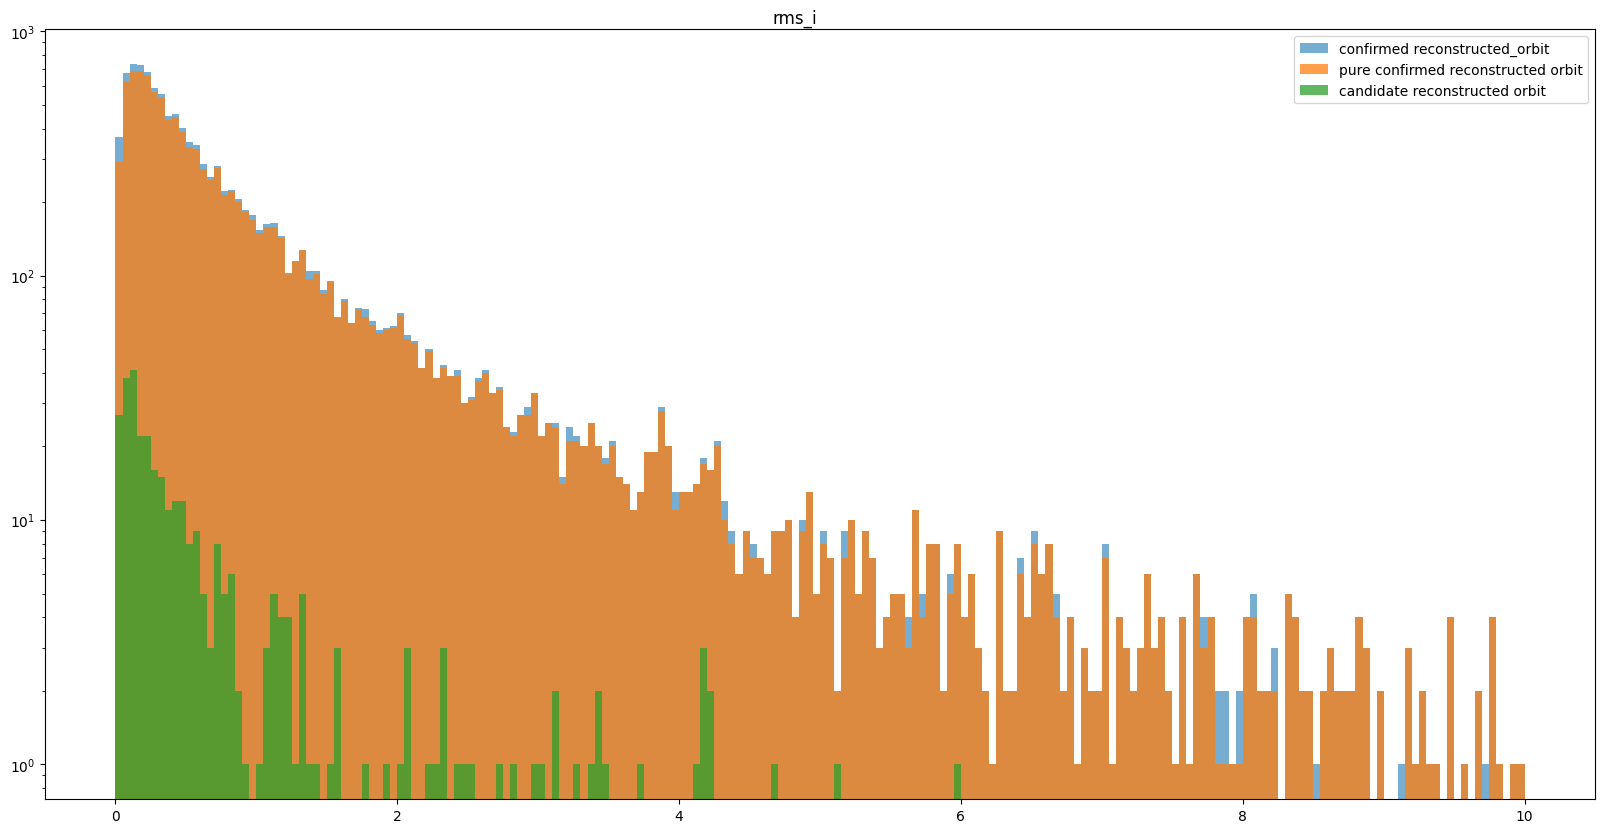

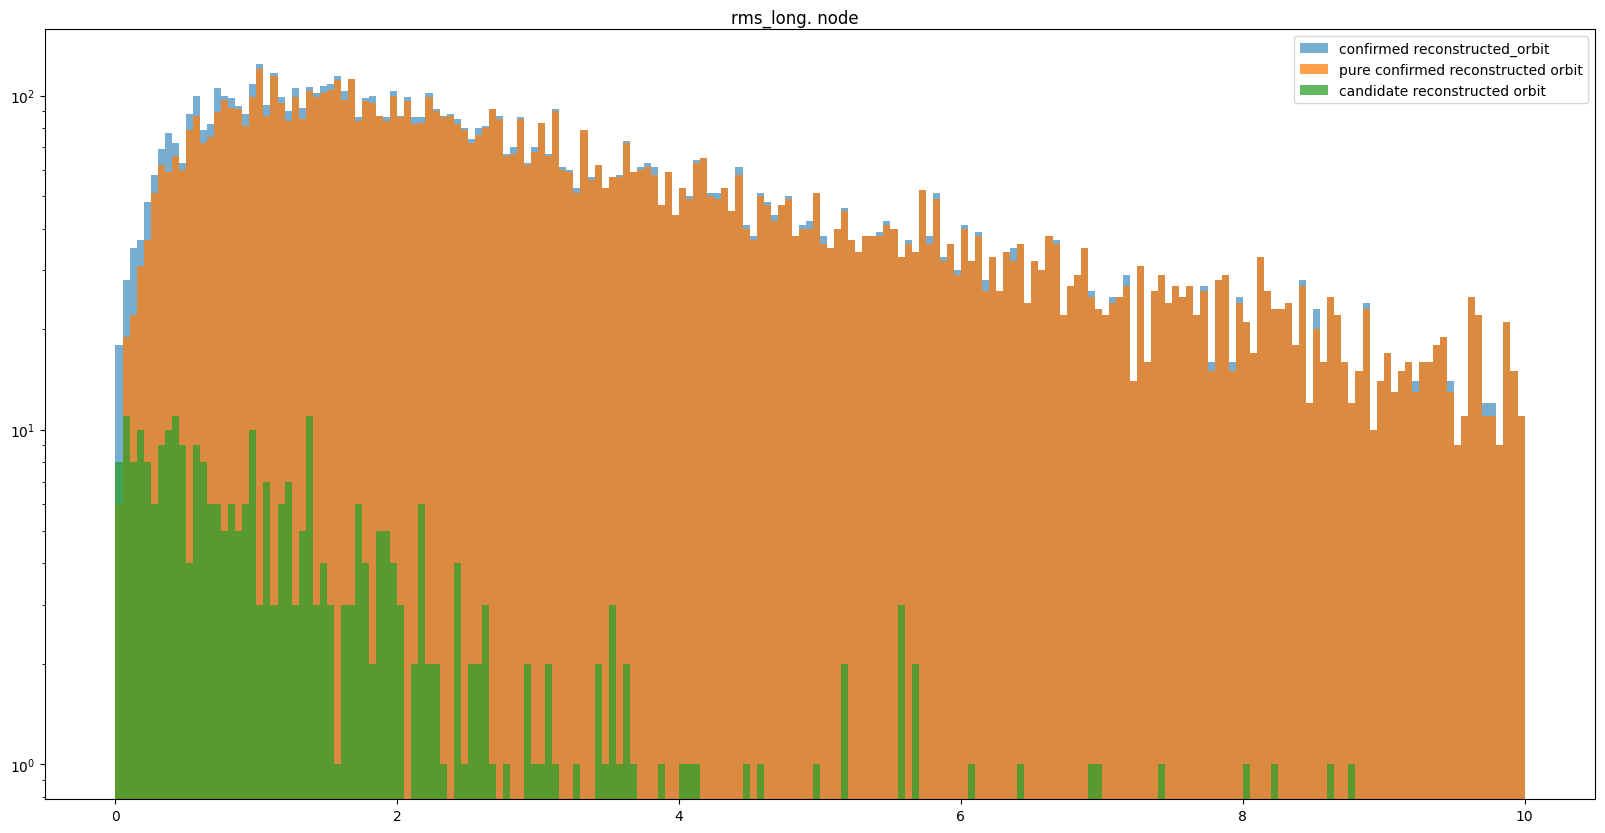

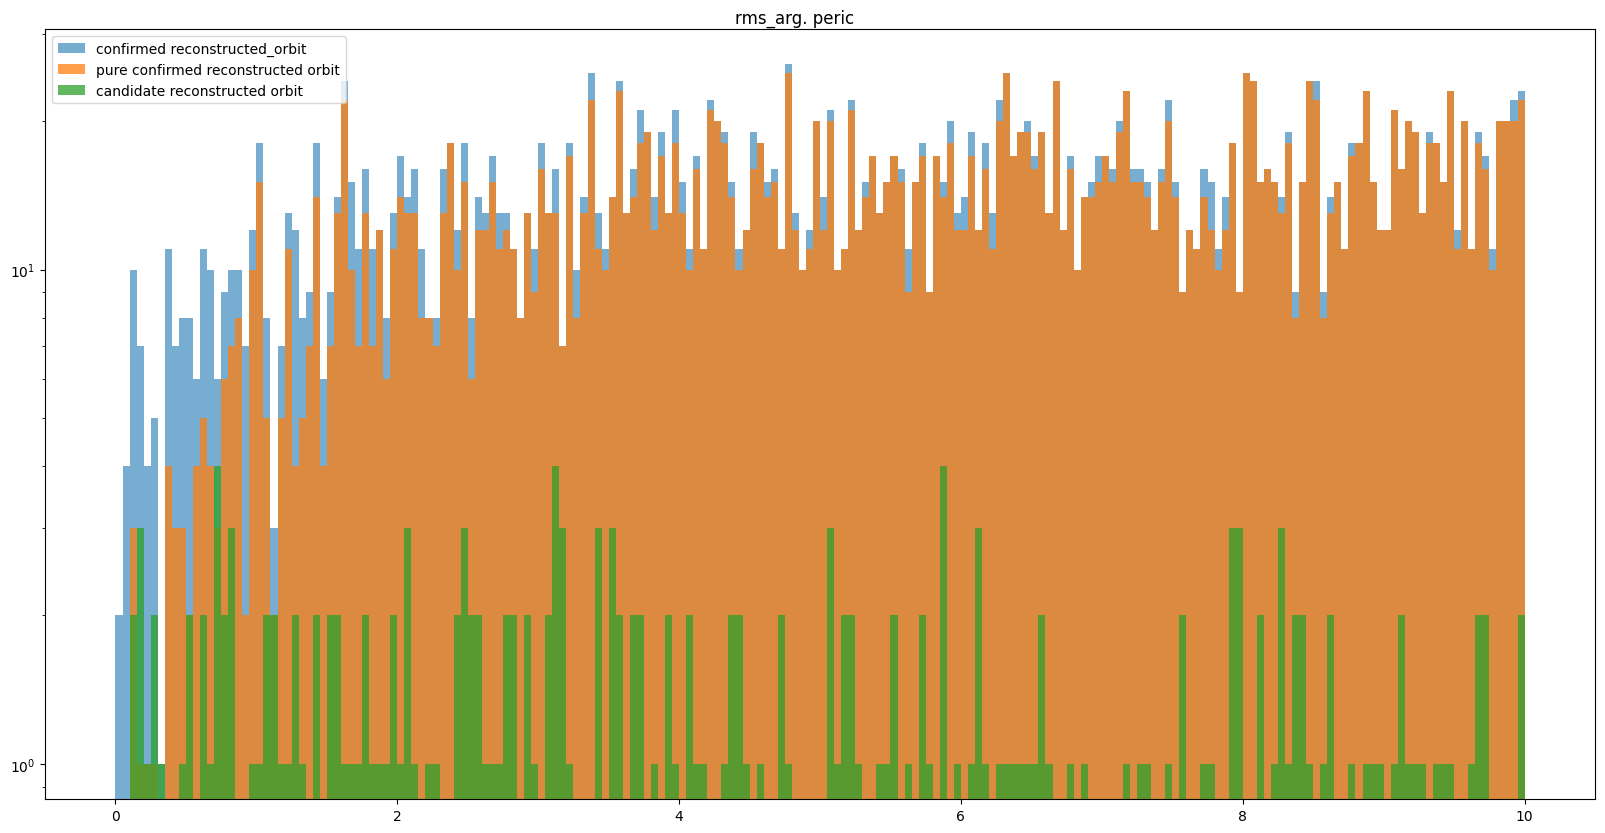

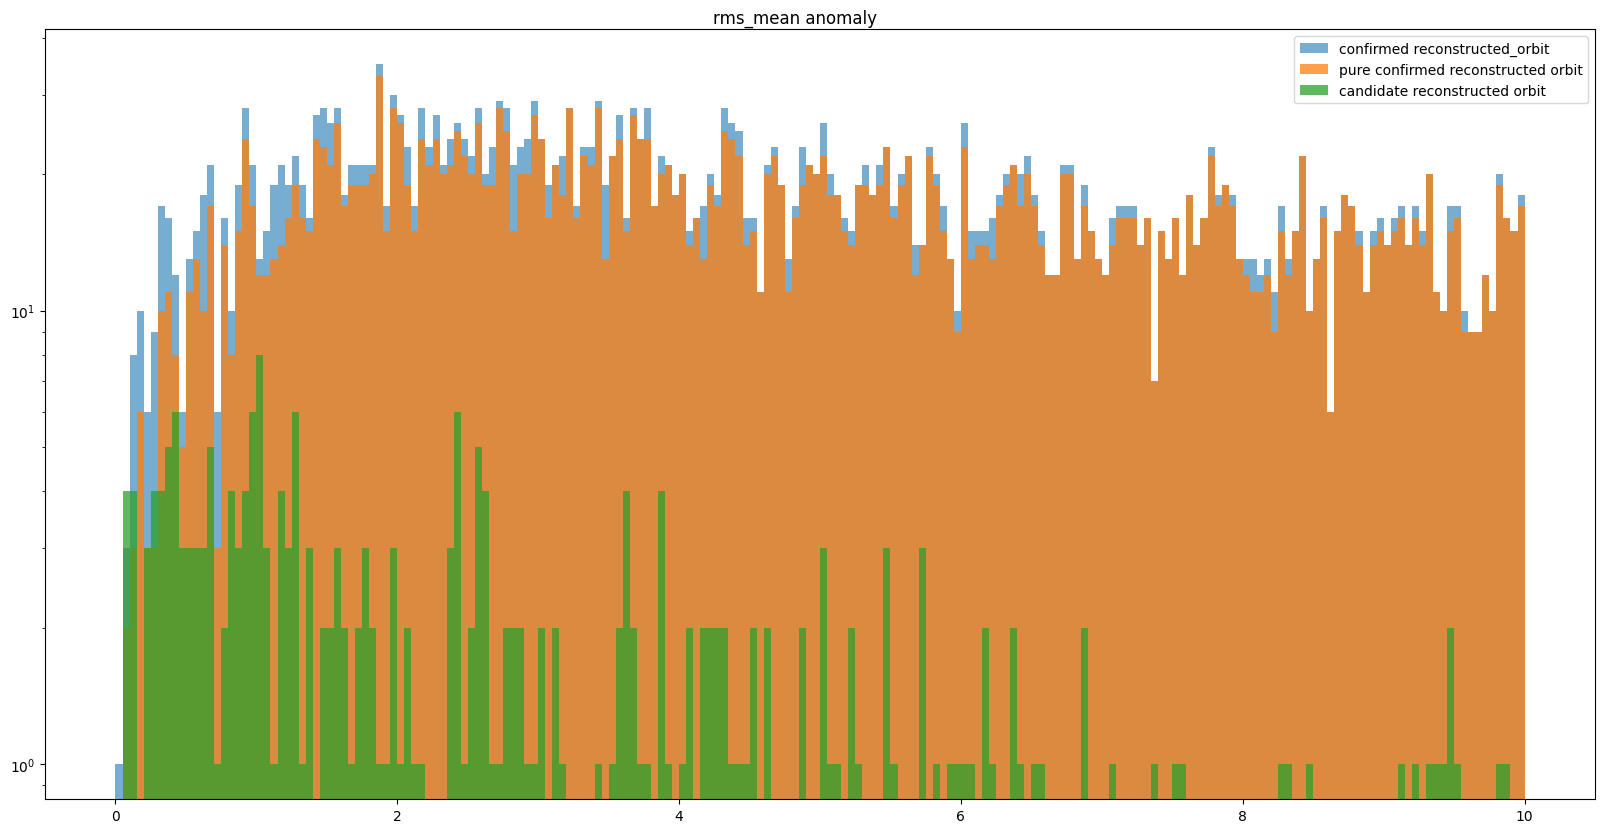

In [12]:
u.compare_confirmed_and_candidates_rms(
    reconstructed_orbit, 
    reconstructed_trajectory, 
    candid_reconstr_orbit[candid_reconstr_orbit["d:rms_a"] != -1.0]
)